## Современные библиотеки градиентного бустинга

Ранее мы использовали наивную версию градиентного бустинга из scikit-learn, [придуманную](https://projecteuclid.org/download/pdf_1/euclid.aos/1013203451) в 1999 году Фридманом. С тех пор было предложено много реализаций, которые оказываются лучше на практике. На сегодняшний день популярны три библиотеки, реализующие градиентный бустинг:
* XGBoost. После выхода быстро набрала популярность и оставалась стандартом до конца 2016 года. Одними из основных особенностей имплементации были оптимизированность построения деревьев, а также различные регуляризации модели.
* LightGBM. Отличительной чертой является быстрота построения композиции. Например, используется следующий трюк для ускорения обучения: при построении вершины дерева вместо перебора по всем значениям признака производится перебор значений гистограммы этого признака. Таким образом, вместо $O(\ell)$ требуется $O(\text{#bins})$. Кроме того, в отличие от других библиотек, которые строят дерево по уровням, LightGBM использует стратегию best-first, т.е. на каждом шаге строит вершину, дающую наибольшее уменьшение функционала. Таким образом, каждое дерево является цепочкой с прикрепленными листьями.
* CatBoost. Библиотека от компании Яндекс. Позволяет автоматически обрабатывать категориальные признаки (даже если их значения представлены в виде строк). Кроме того, алгоритм является менее чувствительным к выбору конкретных гиперпараметров. За счёт этого уменьшается время, которое тратит человек на подбор оптимальных гиперпараметров.

### Основные параметры

(lightgbm/catboost)

* objective – функционал, на который будет настраиваться композиция
* eta / learning_rate – темп (скорость) обучения
* num_iterations / n_estimators  – число итераций бустинга

#### Параметры, отвечающие за сложность деревьев
* max_depth – максимальная глубина 
* max_leaves / num_leaves – максимальное число вершин в дереве
* gamma / min_gain_to_split – порог на уменьшение функции ошибки при расщеплении в дереве
* min_data_in_leaf – минимальное число объектов в листе
* min_sum_hessian_in_leaf – минимальная сумма весов объектов в листе, минимальное число объектов, при котором делается расщепление 
* lambda – коэффициент регуляризации (L2)
* subsample / bagging_fraction – какую часть объектов обучения использовать для построения одного дерева 
* colsample_bytree / feature_fraction – какую часть признаков использовать для построения одного дерева 

Подбор всех этих параметров — настоящее искусство. Но начать их настройку можно с самых главных параметров: learning_rate и n_estimators. Обычно один из них фиксируют, а оставшийся из этих двух параметров подбирают (например, фиксируют n_estimators=1000 и подбирают learning_rate). Следующим по важности является max_depth. В силу того, что мы заинтересованы в неглубоких деревьях, обычно его перебирают из диапазона [3; 7].




In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
!pip install catboost
!pip install lightgbm
!pip install xgboost

In [3]:
from sklearn.datasets import make_classification
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

def plot_surface(X, y, clf):
    h = 0.2
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(8, 8))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

X, y = make_classification(n_samples=500, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0,
                           n_classes=2, n_clusters_per_class=2,
                           flip_y=0.05, class_sep=0.8, random_state=241)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=241)

## Catboost

0.919452347083926


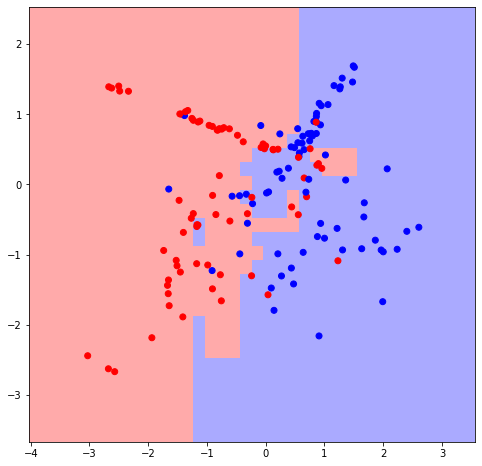

In [4]:
from catboost import CatBoostClassifier 

clf = CatBoostClassifier(iterations=300, logging_level='Silent')
clf.fit(X_train, y_train)
plot_surface(X_test, y_test, clf)

print(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

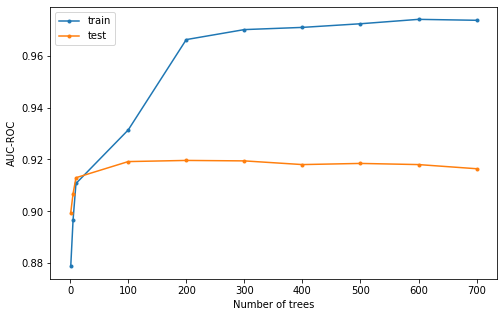

In [5]:
n_trees = [1, 5, 10, 100, 200, 300, 400, 500, 600, 700]
quals_train = []
quals_test = []
for n in n_trees:
    clf = CatBoostClassifier(iterations=n, logging_level='Silent')
    clf.fit(X_train, y_train)
    q_train = roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1])
    q_test = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    quals_train.append(q_train)
    quals_test.append(q_test)
    
plt.figure(figsize=(8, 5))
plt.plot(n_trees, quals_train, marker='.', label='train')
plt.plot(n_trees, quals_test, marker='.', label='test')
plt.xlabel('Number of trees')
plt.ylabel('AUC-ROC')
plt.legend()

plt.show()

## LightGBM

0.8629089615931721


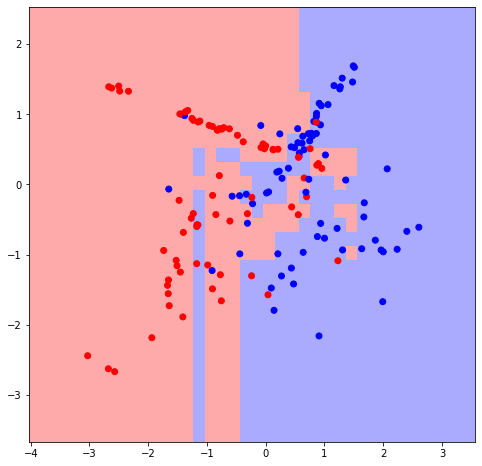

In [6]:
from lightgbm import LGBMClassifier

clf = LGBMClassifier(n_estimators=300)
clf.fit(X_train, y_train)
plot_surface(X_test, y_test, clf)

print(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

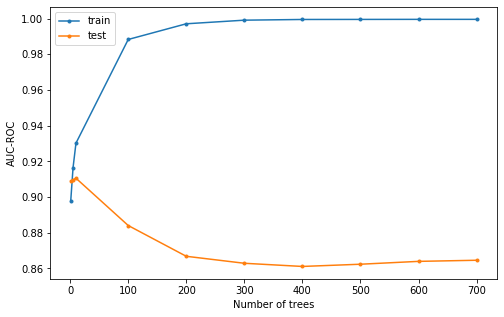

In [7]:
n_trees = [1, 5, 10, 100, 200, 300, 400, 500, 600, 700]
quals_train = []
quals_test = []
for n in n_trees:
    clf = LGBMClassifier(n_estimators=n)
    clf.fit(X_train, y_train)
    q_train = roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1])
    q_test = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    quals_train.append(q_train)
    quals_test.append(q_test)
    
plt.figure(figsize=(8, 5))
plt.plot(n_trees, quals_train, marker='.', label='train')
plt.plot(n_trees, quals_test, marker='.', label='test')
plt.xlabel('Number of trees')
plt.ylabel('AUC-ROC')
plt.legend()

plt.show()

Теперь попробуем взять фиксированное количество деревьев, но будем менять их глубину.

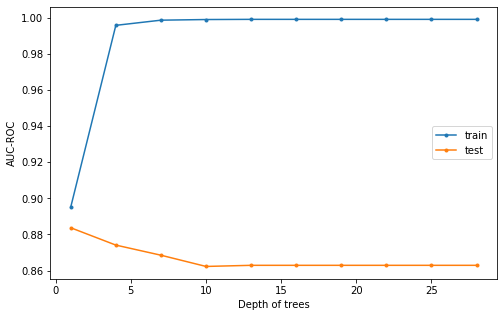

In [8]:
depth = list(range(1, 30, 3))
n_trees = 300
quals_train = []
quals_test = []
for d in depth:
    lgb = LGBMClassifier(n_estimators=n_trees, max_depth=d)
    lgb.fit(X_train, y_train)
    q_train = roc_auc_score(y_train, lgb.predict_proba(X_train)[:, 1])
    q_test = roc_auc_score(y_test, lgb.predict_proba(X_test)[:, 1])
    quals_train.append(q_train)
    quals_test.append(q_test)
    
plt.figure(figsize=(8, 5))
plt.plot(depth, quals_train, marker='.', label='train')
plt.plot(depth, quals_test, marker='.', label='test')
plt.xlabel('Depth of trees')
plt.ylabel('AUC-ROC')
plt.legend()

plt.show()

И сравним с Catboost:

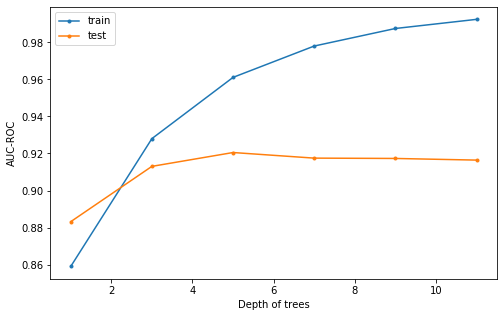

In [9]:
depth = list(range(1, 12, 2))
n_trees = 300
quals_train = []
quals_test = []
for d in depth:
    clf = CatBoostClassifier(n_estimators=n_trees, max_depth=d, logging_level="Silent")
    clf.fit(X_train, y_train)
    q_train = roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1])
    q_test = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    quals_train.append(q_train)
    quals_test.append(q_test)
    
plt.figure(figsize=(8, 5))
plt.plot(depth, quals_train, marker='.', label='train')
plt.plot(depth, quals_test, marker='.', label='test')
plt.xlabel('Depth of trees')
plt.ylabel('AUC-ROC')
plt.legend()

plt.show()

Теперь, когда у нас получились отличные модели, нужно их сохранить!

In [10]:
lgb.booster_.save_model('lightgbm.txt')

clf.save_model('catboost.cbm', format='cbm')

И загрузим обратно, когда понадобится их применить

In [11]:
lgb = LGBMClassifier(model_file='mode.txt')

clf = clf.load_model('catboost.cbm')

## Блендинг

Блендинг представляет из себя "мета-алгоритм", предсказание которого строится как взвешенная сумма базовых алгоритмов. Рассмотрим простой пример блендинга бустинга и линейной регрессии.

In [12]:
from sklearn.datasets import load_boston

data = load_boston()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

def rmse(y_true, y_pred):
    error = (y_true - y_pred) ** 2
    return np.sqrt(np.mean(error))

In [13]:
from catboost import CatBoostRegressor

cbm = CatBoostRegressor(iterations=100, max_depth=4, learning_rate=0.01, loss_function='RMSE', logging_level='Silent')
cbm.fit(X_train, y_train)

y_pred_cbm = cbm.predict(X_test)
y_train_pred_cbm = cbm.predict(X_train)

print("Train RMSE GB = %.4f" % rmse(y_train, y_train_pred_cbm))
print("Test RMSE GB = %.4f" % rmse(y_test, y_pred_cbm))

Train RMSE GB = 5.4431
Test RMSE GB = 6.5456


In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
y_train_pred_lr = lr.predict(X_train_scaled)

print("Train RMSE LR = %.4f" % rmse(y_train, y_train_pred_lr))
print("Test RMSE LR = %.4f" % rmse(y_test, y_pred_lr))

Train RMSE LR = 4.4113
Test RMSE LR = 5.4154


Для простоты будем считать, что новый алгоритм $a(x)$ представим как
$$
    a(x)
    =
    \sum_{n = 1}^{N}
    w_n b_n(x),
$$
где $\sum\limits_{n=1}^N w_n =1$

In [15]:
def select_weights(y_true, y_pred_1, y_pred_2):
    grid = np.linspace(0, 1, 1000)
    metric = []
    for w_0 in grid:
        w_1 = 1 - w_0
        y_a = w_0 * y_pred_1 + w_1 * y_pred_2
        metric.append([rmse(y_true, y_a), w_0, w_1])
    return metric

In [16]:
rmse_blending_train, w_0, w_1 = min(select_weights(y_train, y_train_pred_cbm, y_train_pred_lr), key=lambda x: x[0])

In [17]:
rmse_blending_train

4.273424051954005

In [18]:
rmse(y_test, y_pred_cbm * w_0 +  y_pred_lr * w_1)

5.237314717927904

In [19]:
from lightgbm import LGBMRegressor

def stack_models(model, y_true, y_pred_1, y_pred_2):
    sample = pd.DataFrame([y_pred_1, y_pred_2]).T
    model.fit(sample, y_true)
    return model

lgb = LGBMRegressor(n_estimators=200, max_depth=3)
lgb = stack_models(lgb, y_train, y_train_pred_cbm, y_train_pred_lr)
rmse(y_test, lgb.predict(pd.DataFrame([y_pred_cbm, y_pred_lr]).T))

4.315187170527423

В итоге получаем качество на тестовой выборке лучше, чем у каждого алгоритма в отдельности.

Полезные ссылки:

* [Видео про стекинг](https://www.coursera.org/lecture/competitive-data-science/stacking-Qdtt6)
* [Продвинутый вариант стекинга с использованием нейросетей](https://www.coursera.org/learn/competitive-data-science/lecture/s8RLi/stacknet)

## Важность признаков

В курсе мы подробно обсуждаем, как добиваться хорошего качества решения задачи: имея выборку $X, y$, построить алгоритм с наименьшей ошибкой. Однако заказчику часто важно понимать, как работает алгоритм, почему он делает такие предсказания. Обсудим несколько мотиваций.
	
#### Доверие алгоритму
Например, в банках на основе решений, принятых алгоритмом, выполняются финансовые операции, и менеджер, ответственный за эти операции, будет готов использовать алгоритм, только если он понимает, что его решения обоснованы. По этой причине в банках очень часто используют простые линейные алгоритмы. Другой пример из области медицины: поскольку цена ошибки может быть очень велика, врачи готовы использовать только интерпретируемые алгоритмы.
	
#### Отсутствие дискриминации (fairness) 
Вновь пример с банком: алгоритм кредитного скоринга не должен учитывать расовую принадлежность (racial bias) заемщика или его пол (gender bias). Между тем, такие зависимости часто могут присутствовать в датасете (исторические данные), на котором обучался алгоритм.  Еще один пример: известно, что нейросетевые векторы слов содержат gender bias. Если эти вектора использовались при построении системы поиска по резюме для рекрутера, то, например, по запросу `technical skill` он может видеть женские резюме в конце ранжированного списка.
	
#### Учет контекста
Данные, на которых обучается алгоритм, не отображают всю предметную область. Интерпретация алгоритма позволит оценить, насколько найденные зависимости связаны с реальной жизнью. Если предсказания интерпретируемы, это также говорит о высокой обобщающей способности алгоритма. 

Теперь обсудим несколько вариантов, как можно оценивать важность признаков.

### Веса линейной модели

Самый простой способ, который уже был рассмотрен на семинаре про линейные модели: после построения модели каждому признаку будет соответствовать свой вес - если признаки масштабированы, то чем он больше по модулю, тем важнее признак, а знак будет говорить о положительном или отрицательном влиянии на величину целевой переменной.

### FSTR (Feature strength)

[Fstr](https://catboost.ai/docs/concepts/fstr.html) говорит, что важность признака &mdash; это то, насколько в среднем меняется ответ модели при изменении значения данного признака (изменении значения разбиения).

Рассчитать его можно так:

$$feature\_importance_{F} = \sum_{tree, leaves_F} (v_1 - avr)^2\cdot c_1 +(v_2 - avr)^2\cdot c_2 = \left(v_1 - v_2\right)^2\frac{c_1c_2}{c_1 + c_2}\\
\qquad avr = \frac{v_1 \cdot c_1 + v_2 \cdot c_2}{c_1 + c_2}.$$

Мы сравниваем листы, отличающиеся значением сплита в узле на пути к ним: если условие сплита выполняется, объект попадает в левое поддерево, иначе &mdash; в правое. 

$c_1, c_2 - $  число объектов обучающего датасета, попавших в левое и правое поддерево соответственно, либо суммарный вес этих объектов, если используются веса; $v1, v2 -$значение модели в левом и правом поддереве (например, среднее)


Далее значения $feature\_importance$ нормируются, и получаются величины, которые суммируются в 100.

In [20]:
for val, name in sorted(zip(cbm.feature_importances_, data.feature_names))[::-1]:
    print(name, val)

LSTAT 44.57842395824728
RM 36.850858175652654
NOX 3.473133901367306
PTRATIO 3.3887271637105134
DIS 2.23667053074621
INDUS 1.9016830079470277
TAX 1.7781003730136429
CRIM 1.5774334311195715
AGE 1.4213295189456003
RAD 1.3943420902109485
B 0.6521915521536685
CHAS 0.6057385942178969
ZN 0.14136770266764145


In [21]:
sum(cbm.feature_importances_)

99.99999999999996

### Out-of-bag

В случайном лесе за счет обучения на подвыборках можно использовать out-of-bag оценки - ошибка композиции $a(x) = \sum_{n=1}^N b_n(x)$, построенной с помощью бэггинга с базовыми алгоритмами $b_i(x)$, вычисляется по формуле (подробнее см. конспект лекции 8):
     $$
     \text{OOB} = \sum_{i=1}^\ell L\biggl(y_i, \frac 1 {\sum_{n=1}^N [x_i \notin X_n]} \sum_{n=1}^N [x_i \notin X_n] b_n(x_i)\biggr)
      $$     
Можно показать, что по мере увеличения числа деревьев 
данная оценка стремится к leave-one-out-оценке,
но при этом существенно проще для вычисления.
     
Итоговый алгоритм подсчета важностей для случайного леса выглядит так:
* Вычислить OOB для случайного леса, обученного по исходной обучающей выборке
*  Для каждого признака $j$:

    * Перемешать значения признака по всем объектам обучающей выборки &mdash; мы хотим сделать признак неинформативным
    * Вычислить OOB$_j$ случайного леса, обученного по измененной обучающей выборке
    * Оценить важности: $R_j = \max(0, \text{OOB}-\text{OOB}_j)$

Приведем простейший пример, как можно получить такую оценку в sklearn-реализации RandomForest

In [22]:
from sklearn.ensemble import RandomForestRegressor

clf = RandomForestRegressor(n_estimators=100, oob_score=True)
clf.fit(X_train, y_train)

clf.oob_score_

0.837337465715185

## Интерпретация алгоритмов

Отдельным направлением исследований является анализ уже построенных алгоритмов. Разберем популярный метод &mdash; [LIME](https://christophm.github.io/interpretable-ml-book/lime.html). 
   
   Предположим, что мы обучили алгоритм $a$ на выборке {$X, y$}, и хотим интерпретировать его предсказания. Алгоритм LIME выполняет локальную интерпретацию, то есть объясняет предсказания для конкретного объекта. Основная идея состоит в локальном приближении разделяющей поверхности алгоритма другим, более простым алгоритмом $b$ (например, линейным). Итак, чтобы объяснить предсказания $a(x)$ на конкретном объекте $x$:
   
* Сгенерировать выборку точек $x_1, \dots, x_m$ около объекта $x$.
* Обучить интерпретируемый алгоритм $b$ на выборке $\{(x_1, a(x_1)), \dots, (x_m, a(x_m))\}$.
* Интерпретировать алгоритм $b$.

   Если мы приближаем разделяющую поверхность линейной функцией $b$, то по обученным весам можно сказать, какой вклад вносит каждый признак в предсказания в окрестности точки $x$.

## XGBoost

In [23]:
# based on https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import metrics   #Additional sklearn functions
from sklearn.model_selection import learning_curve, GridSearchCV  #Perforing grid search
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
from sklearn.datasets import load_breast_cancer, fetch_lfw_pairs, make_classification
rcParams['figure.figsize'] = 12, 4

In [24]:
titanic = pd.read_csv('titanic.csv')

In [25]:
X = titanic[['Pclass', 'Age', 'SibSp', 'Fare']]
y = titanic.Survived.values

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((712, 4), (712,), (179, 4), (179,))

In [28]:
def modelfit(alg, dtrain, y, X_test=None, y_test=None, test=True, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain, label=y)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain, y, eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain)
    dtrain_predprob = alg.predict_proba(dtrain)[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy (Train): %.4g" % metrics.accuracy_score(y, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(y, dtrain_predprob))
    if test:
        dtest_predictions = alg.predict(X_test)
        dtest_predprob = alg.predict_proba(X_test)[:,1]
        print ("Accuracy (Test): %.4g" % metrics.accuracy_score(y_test, dtest_predictions))
        print ("AUC Score (Test): %f" % metrics.roc_auc_score(y_test, dtest_predprob))
    # return alg              
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [29]:
#Choose all predictors except target & IDcols
# predictors = [x for x in X.columns]
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 booster='gbtree',
 seed=27)


Model Report
Accuracy (Train): 0.7683
AUC Score (Train): 0.860549
Accuracy (Test): 0.7542
AUC Score (Test): 0.828121


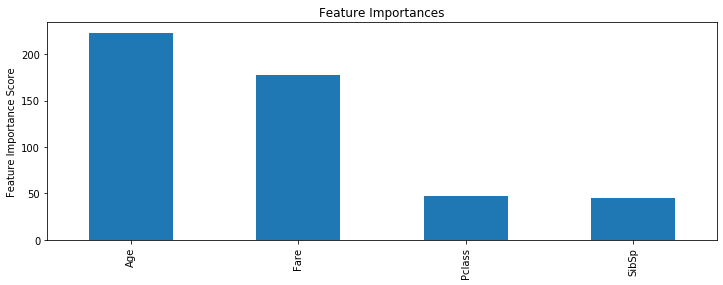

In [30]:
modelfit(xgb1, X_train, y_train, X_test, y_test)

In [31]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train, y_train)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([0.18317962, 0.16056046, 0.16796908, 0.21231685, 0.20918303,
         0.2022604 , 0.2668674 , 0.24509854, 0.23548441, 0.32928619,
         0.30140386, 0.22639384]),
  'std_fit_time': array([0.01373569, 0.00440577, 0.0091231 , 0.00318459, 0.00243955,
         0.00280538, 0.00513693, 0.00760247, 0.01030226, 0.02594715,
         0.01689446, 0.03491538]),
  'mean_score_time': array([0.00760646, 0.00569167, 0.00531669, 0.00531311, 0.00571442,
         0.00520973, 0.00512576, 0.00540028, 0.00478644, 0.00598049,
         0.00548787, 0.00518584]),
  'std_score_time': array([0.00079801, 0.00074517, 0.00041528, 0.00040811, 0.00076616,
         0.00098042, 0.00018963, 0.0007903 , 0.00039861, 0.00089507,
         0.00044599, 0.00039899]),
  'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False, False],
         fill_value='?',
         

In [32]:
param_test2 = {
 'max_depth':[8,9,10],
 'min_child_weight':[4, 5, 6]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(X_train, y_train)
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

({'mean_fit_time': array([0.307903  , 0.34804988, 0.24774818, 0.27143078, 0.32906008,
         0.30152125, 0.31301122, 0.3615037 , 0.2497447 ]),
  'std_fit_time': array([0.05589204, 0.03325847, 0.01809807, 0.00695252, 0.02735876,
         0.01964714, 0.02643524, 0.018745  , 0.04076594]),
  'mean_score_time': array([0.00757985, 0.0075798 , 0.00559859, 0.0065135 , 0.00738034,
         0.0071806 , 0.00618329, 0.0053925 , 0.00558519]),
  'std_score_time': array([0.00079765, 0.00149341, 0.00079576, 0.00136103, 0.00149243,
         0.00146547, 0.00203413, 0.00049753, 0.00048842]),
  'param_max_depth': masked_array(data=[8, 8, 8, 9, 9, 9, 10, 10, 10],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_min_child_weight': masked_array(data=[4, 5, 6, 4, 5, 6, 4, 5, 6],
               mask=[False, False, False, False, False, False, False, False,
                     False],
      

In [33]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=9,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(X_train, y_train)
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

({'mean_fit_time': array([0.249931  , 0.23819494, 0.22511435, 0.21953158, 0.19209313]),
  'std_fit_time': array([0.00360175, 0.00579196, 0.00643353, 0.00474022, 0.02691424]),
  'mean_score_time': array([0.00718174, 0.00738077, 0.00708904, 0.00558233, 0.00498652]),
  'std_score_time': array([1.71724755e-03, 1.35302286e-03, 1.98344899e-03, 7.93519370e-04,
         3.98950589e-07]),
  'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.3, 0.4],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'gamma': 0.0},
   {'gamma': 0.1},
   {'gamma': 0.2},
   {'gamma': 0.3},
   {'gamma': 0.4}],
  'split0_test_score': array([0.70110279, 0.69049105, 0.69434041, 0.69621307, 0.69267582]),
  'split1_test_score': array([0.74032459, 0.7406367 , 0.74115689, 0.74042863, 0.7488556 ]),
  'split2_test_score': array([0.75260092, 0.75925926, 0.75821889, 0.76009155, 0.74656679]),
  'split3_test_score': array([0.70256519, 0.70934916, 0.704685


Model Report
Accuracy (Train): 0.7992
AUC Score (Train): 0.885610
Accuracy (Test): 0.743
AUC Score (Test): 0.814414


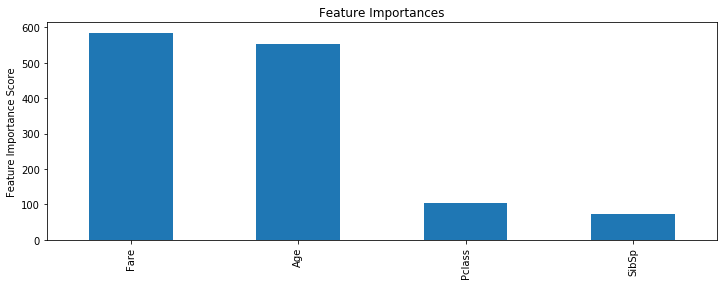

In [34]:
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=9,
 min_child_weight=6,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 booster='gbtree',
 seed=27)
modelfit(xgb2, X_train, y_train, X_test, y_test)

In [35]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=9,
 min_child_weight=6, gamma=0., subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(X_train, y_train)
gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_

({'mean_fit_time': array([0.21233482, 0.22849751, 0.23966742, 0.25968485, 0.2342567 ,
         0.2251555 , 0.23696604, 0.24376493, 0.23577752, 0.25223246,
         0.34148626, 0.30179243, 0.25950499, 0.25272346, 0.29620714,
         0.27426519]),
  'std_fit_time': array([0.00608918, 0.0056285 , 0.00959508, 0.00289798, 0.00593574,
         0.0069852 , 0.00354619, 0.00329796, 0.00310082, 0.00339207,
         0.06923406, 0.05276925, 0.01257483, 0.00299794, 0.02836307,
         0.03688979]),
  'mean_score_time': array([0.00658159, 0.00578485, 0.00508871, 0.00520658, 0.00609975,
         0.00578399, 0.00548906, 0.00478649, 0.00498676, 0.0047873 ,
         0.00498571, 0.00498619, 0.00538602, 0.00498595, 0.00498652,
         0.00558462]),
  'std_score_time': array([1.49281470e-03, 7.46187409e-04, 4.86269047e-04, 4.05613618e-04,
         1.01486909e-03, 1.16298203e-03, 4.46520316e-04, 3.98159455e-04,
         3.98950589e-07, 3.98564663e-04, 1.32831462e-06, 7.47889859e-07,
         7.98630777e-

In [36]:
param_test5 = {
 'subsample':[i/100.0 for i in range(55, 70, 5)],
 'colsample_bytree':[i/100.0 for i in range(55, 70,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=9,
 min_child_weight=6, gamma=0., subsample=0.6, colsample_bytree=0.6,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(X_train, y_train)
gsearch5.cv_results_, gsearch5.best_params_, gsearch5.best_score_

({'mean_fit_time': array([0.22120852, 0.2194128 , 0.22360168, 0.21003771, 0.25566392,
         0.26800079, 0.24794273, 0.26543121, 0.23430939]),
  'std_fit_time': array([0.00438887, 0.00652588, 0.01127208, 0.00482819, 0.01143106,
         0.00247196, 0.00507755, 0.00487112, 0.04188806]),
  'mean_score_time': array([0.00618372, 0.00558581, 0.00558496, 0.00598388, 0.00719743,
         0.00619321, 0.0059978 , 0.00582333, 0.00519414]),
  'std_score_time': array([0.00074665, 0.0007983 , 0.00119702, 0.00089212, 0.00205272,
         0.00073082, 0.00126204, 0.00074881, 0.00039524]),
  'param_colsample_bytree': masked_array(data=[0.55, 0.55, 0.55, 0.6, 0.6, 0.6, 0.65, 0.65, 0.65],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_subsample': masked_array(data=[0.55, 0.6, 0.65, 0.55, 0.6, 0.65, 0.55, 0.6, 0.65],
               mask=[False, False, False, False, False, False, Fals

In [37]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=9,
 min_child_weight=6, gamma=0., subsample=0.6, colsample_bytree=0.55,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(X_train, y_train)
gsearch6.cv_results_, gsearch6.best_params_, gsearch6.best_score_

({'mean_fit_time': array([0.25271497, 0.22541203, 0.23938894, 0.24633584, 0.12297292]),
  'std_fit_time': array([0.01703447, 0.01646926, 0.00402761, 0.01535145, 0.02168237]),
  'mean_score_time': array([0.00998154, 0.00751338, 0.00619445, 0.0081779 , 0.00718069]),
  'std_score_time': array([0.00431634, 0.0014789 , 0.00117176, 0.00247477, 0.00159636]),
  'param_reg_alpha': masked_array(data=[1e-05, 0.01, 0.1, 1, 100],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'reg_alpha': 1e-05},
   {'reg_alpha': 0.01},
   {'reg_alpha': 0.1},
   {'reg_alpha': 1},
   {'reg_alpha': 100}],
  'split0_test_score': array([0.70016646, 0.70307948, 0.70640866, 0.70547233, 0.5       ]),
  'split1_test_score': array([0.73678735, 0.7340824 , 0.73512276, 0.74490221, 0.5       ]),
  'split2_test_score': array([0.78256346, 0.77985851, 0.78422805, 0.7741365 , 0.5       ]),
  'split3_test_score': array([0.70171719, 0.70659317, 0.70786517,


Model Report
Accuracy (Train): 0.7921
AUC Score (Train): 0.872134
Accuracy (Test): 0.7486
AUC Score (Test): 0.792085


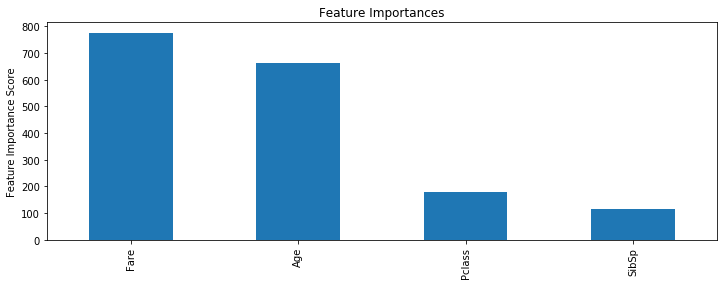

In [38]:
xgb3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=9,
 min_child_weight=6,
 gamma=0,
 subsample=0.6,
 colsample_bytree=0.55,
 reg_alpha = 1e-05,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb3, X_train, y_train, X_test, y_test)


Model Report
Accuracy (Train): 0.7879
AUC Score (Train): 0.872382
Accuracy (Test): 0.7765
AUC Score (Test): 0.810167


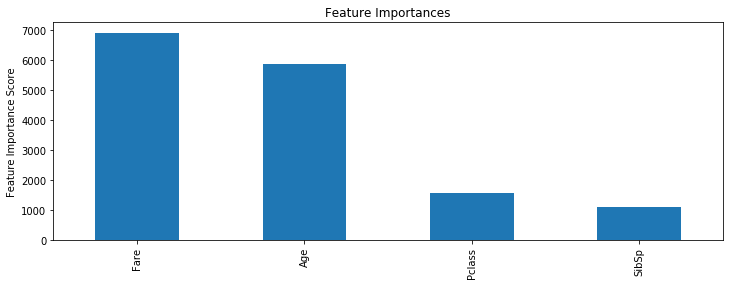

In [39]:
xgb3 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=9,
 min_child_weight=6,
 gamma=0,
 subsample=0.6,
 colsample_bytree=0.55,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb3, X_train, y_train, X_test, y_test, early_stopping_rounds=500)

## Multi-class метрики

In [40]:
# https://stackoverflow.com/questions/9004172/precision-recall-for-multiclass-multilabel-classification
# https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff
# https://scikit-learn.org/stable/modules/multiclass.html
# https://scikit-learn.org/stable/modules/model_evaluation.html#multiclass-and-multilabel-classification

In [41]:
from sklearn import metrics
import numpy as np

In [42]:
y_true = np.array([0, 1, 2, 0, 1, 2, 2, 2, 3])
y_pred = np.array([0, 2, 1, 0, 0, 1, 3, 3, 3])

In [43]:
# micro 
TP = 0
FP = 0
TN = 0
FN = 0

for i in range(4):
    TP += ((y_true == i) * (y_pred == i)).sum()
    FP += ((y_true != i) * (y_pred == i)).sum()
    TN += ((y_true != i) * (y_pred != i)).sum()
    FN += ((y_true == i) * (y_pred != i)).sum()

micro_P, micro_R = TP/(TP+FP), TP/(TP+FN)
micro_P, micro_R

(0.3333333333333333, 0.3333333333333333)

In [44]:
# macro 
macro_P, macro_R = 0, 0

for i in range(4):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    
    TP += ((y_true == i) * (y_pred == i)).sum()
    FP += ((y_true != i) * (y_pred == i)).sum()
    TN += ((y_true != i) * (y_pred != i)).sum()
    FN += ((y_true == i) * (y_pred != i)).sum()

    macro_P += TP/(TP+FP)
    macro_R += TP/(TP+FN)
    
macro_P /= 4
macro_R /= 4

macro_P, macro_R

(0.25, 0.5)

In [45]:
metrics.precision_score(y_true, y_pred, average='micro')

0.3333333333333333

In [46]:
metrics.recall_score(y_true, y_pred, average='micro')

0.3333333333333333

In [47]:
metrics.precision_score(y_true, y_pred, average='macro')

0.25

In [48]:
metrics.recall_score(y_true, y_pred, average='macro')

0.5